In [96]:
import pandas as pd
import torch
from torch_geometric.data import Data
from rdkit import Chem
import numpy as np
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

atoms = set([6, 7, 8, 9, 14, 15, 16, 17, 35, 53])

def get_bond_type_one_hot(bond):
    bond_type_one_hot = [0, 0, 0, 0]
    
    if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
        bond_type_one_hot[0] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
        bond_type_one_hot[1] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
        bond_type_one_hot[2] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
        bond_type_one_hot[3] = 1
    
    return bond_type_one_hot

def get_bond_type_int(bond):
    if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
        return 0
    elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
        return 1
    elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
        return 2
    elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
        return 3

def process_molecule(mol, node_dim=100, atomic_to_index=None, label = 'bio'):
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in atoms:
    # atomic_numbers = set([atom.GetAtomicNum() for atom in mol.GetAtoms()])
            return None, None, None, None
    # x = torch.nn.functional.one_hot(torch.tensor(atomic_numbers) - 1, num_classes=node_dim).float()
    atomic_indices = [atomic_to_index[atom.GetAtomicNum()] for atom in mol.GetAtoms()]
    x = torch.nn.functional.one_hot(torch.tensor(atomic_indices), num_classes=len(atomic_to_index)).float()
    # x = torch.nn.functional.one_hot(torch.tensor(atomic_indices), num_classes=len(atomic_to_index))

    labels_bio = -1
    name = '-1'
    # print(list(mol.GetPropNames()))
    for prop in mol.GetPropNames():
                if prop == "ReadyBiodegradability":
                    labels_bio = (int(mol.GetProp(prop)))
    if label == 'tox':
        name = mol.GetProp('_Name')
    # print(name)
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append([start, end])
        bond_type = get_bond_type_one_hot(bond)
        # bond_type = get_bond_type_int(bond)
        pos_start, pos_end = mol.GetConformer().GetAtomPosition(start), mol.GetConformer().GetAtomPosition(end)
        distance = np.linalg.norm(np.array(pos_start) - np.array(pos_end))
        # edge_attr.append(bond_type + [distance])
        edge_attr.append(bond_type)

    formula = CalcMolFormula(mol)
    bio = labels_bio

    anum = []
    degs = []
    chargs = []
    hybs = []
    hs = []
    elec = []
    aro = []
    rings = []

    for atom in mol.GetAtoms():
        anum.append(torch.nn.functional.one_hot(torch.tensor(atomic_to_index.get(atom.GetAtomicNum())), num_classes=len(atomic_to_index)))
        degs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetDegree()), num_classes=7))
        chargs.append(torch.tensor(atom.GetFormalCharge(), dtype=torch.int64))
        hybs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetHybridization()), num_classes=8))
        hs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetNumExplicitHs()), num_classes=6))

        elec.append(torch.tensor(atom.GetNumRadicalElectrons(), dtype=torch.int64))
        aro.append(torch.tensor(int(atom.GetIsAromatic())))
        rings.append(torch.tensor(int(atom.IsInRing())))


    anum = torch.stack(anum)
    degs = torch.stack(degs)
    chargs = torch.stack(chargs).unsqueeze(-1)
    hybs = torch.stack(hybs)
    hs = torch.stack(hs)
    elec = torch.stack(elec).unsqueeze(-1)
    aro = torch.stack(aro).unsqueeze(-1)
    rings = torch.stack(rings).unsqueeze(-1)
    atom_features = torch.cat([anum, degs, chargs, hybs, hs, elec, aro, rings], dim=1)
    
    d = Data(x=x, atom_data = atom_features, edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(), edge_attr=torch.tensor(edge_attr, dtype=torch.long))
    return formula, d, bio, name

def load_molecules(sdf_path, atomic_to_index = None, label = 'bio'):
    formula_list = []
    d_list = []
    bio_list = []
    name_list = []
    num_atoms_list = []
    suppl = Chem.SDMolSupplier(sdf_path)
    # i = 0
    for mol in tqdm(suppl):
        if mol is not None:
            # if i%1000 == 0:
            #     print(i)
            # i+=1
            formula, d, bio, name = process_molecule(mol, atomic_to_index= atomic_to_index, label=label)
            if formula is None:
                continue
            formula_list.append(formula)
            d_list.append(d)
            bio_list.append(bio)
            name_list.append(name)
            num_atoms_list.append(mol.GetNumAtoms())
    if label == 'bio':
        return pd.DataFrame({'formula': formula_list, 'data_object': d_list, 'node_dim':num_atoms_list, 'bio': bio_list})
    if label == 'tox':
        return pd.DataFrame({'formula': formula_list, 'data_object': d_list, 'node_dim':num_atoms_list, 'name': name_list})
    return 'error'


def load_toxicity_labels(csv_path):
    labels_df = pd.read_csv(csv_path)
    overall_toxicity = labels_df.iloc[:, 1:].sum(axis=1) > 0
    tox = [int(x) for x in overall_toxicity]
    return pd.DataFrame({'name': labels_df.iloc[:,0], 'tox': tox})

def check_num_elements(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)

    elements = set()

    for mol in suppl:
        if mol is not None:
            for atom in mol.GetAtoms():
                elements.add(atom.GetAtomicNum())

    return elements

def check_num_counts(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)

    elements = {}

    for mol in suppl:
        if mol is not None:
            for atom in mol.GetAtoms():
                num = atom.GetAtomicNum()
                if num in elements:
                    elements[num]+=1
                else:
                    elements[num] = 1

    return elements

def plot_cumulative_distribution(elements):

    items = sorted(elements.items())
    atomic_numbers, counts = zip(*items)

  
    cumulative_counts = np.cumsum(counts)
    total = cumulative_counts[-1]
  
    percentiles = [90, 95, 99]
    percentile_values = {p: np.percentile(cumulative_counts, p) for p in percentiles}


    plt.figure(figsize=(10, 6))
    plt.bar([i for i in range(len(atomic_numbers))], cumulative_counts, color='blue', label='Cumulative counts')
    for p, value in percentile_values.items():
        plt.axhline(y=value, color='red', linestyle='--', label=f'{p}th percentile ({value:.2f})')
    
    plt.xlabel('Atomic Number')
    plt.ylabel('Cumulative Count')
    plt.title('Cumulative Distribution of Atomic Numbers')
    plt.legend()
    plt.grid(True)
    plt.show()

def calc_node_dim(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)

    max_dim = 0

    for mol in suppl:
        if mol is not None:
            max_dim = max(max_dim, mol.GetNumAtoms())

    return max_dim

def plot_atoms_distribution(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)
    atom_counts = []

    for mol in suppl:
        if mol is not None:
            atom_counts.append(mol.GetNumAtoms())

   
    percentiles = np.percentile(atom_counts, [90, 95, 99])

    plt.figure(figsize=(10, 6))
    plt.hist(atom_counts, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')
    plt.title('Distribution of Atom Counts per Molecule')

    for percentile, value in zip([90, 95, 99], percentiles):
        plt.axvline(x=value, color='r', linestyle='--', label=f'{percentile}th percentile: {value}')

    plt.legend()
    plt.show()

def plot_atoms_distribution_from_list(l):

    percentiles = np.percentile(l, [90, 95, 99])

    plt.figure(figsize=(10, 6))
    plt.hist(l, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')
    plt.title('Distribution of Atom Counts per Molecule')


    for percentile, value in zip([90, 95, 99], percentiles):
        plt.axvline(x=value, color='r', linestyle='--', label=f'{percentile}th percentile: {value}')

    plt.legend()
    plt.show()

def convert_to_tensors(data_object, max_atomic_index=10, node_dim=63, max_bond_dim=4):
    bond_type_tensor = torch.zeros((node_dim, node_dim, max_bond_dim + 1), dtype=torch.float32)
    # distance_tensor = torch.zeros((node_dim, node_dim, 1), dtype=torch.float32)
    atomic_num_tensor = torch.zeros((node_dim, max_atomic_index + 1), dtype=torch.float32)
    
    num_atoms = data_object.x.size(0)
    atomic_num_tensor[:num_atoms, :-1] = data_object.x.clone()
    
    no_atom_present = (atomic_num_tensor.sum(dim=1) == 0)
    atomic_num_tensor[no_atom_present, -1] = 1


    edge_index = data_object.edge_index.numpy()
    edge_attr = data_object.edge_attr.numpy()
    
    for i, (start, end) in enumerate(edge_index.T):
        if start < node_dim and end < node_dim:
            bond_info = torch.tensor(edge_attr[i][:4], dtype=torch.float32)
            # print(max(bond_info))
            # distance_info = torch.tensor(edge_attr[i][-1], dtype=torch.float32)
            
            bond_type_tensor[start, end, :-1] = bond_info
            bond_type_tensor[end, start, :-1] = bond_info

            # if bond_info.sum() == 0:
            #     bond_type_tensor[start, end, -1] = 1
            #     bond_type_tensor[end, start, -1] = 1

            # distance_tensor[start, end, 0] = distance_info
            # distance_tensor[end, start, 0] = distance_info
                
    for i in range(node_dim):
        for j in range(node_dim):
            if torch.all(bond_type_tensor[i, j, :-1] == 0):
                bond_type_tensor[i, j, -1] = 1
                bond_type_tensor[j, i, -1] = 1 
    # return bond_type_tensor, distance_tensor, atomic_num_tensor
    return bond_type_tensor, atomic_num_tensor
def count_atomic_numbers(atomic_num_tensor):


    atomic_counts = torch.sum(atomic_num_tensor, dim=(0, 1))

    atomic_number_counts = {}
    for i, count in enumerate(atomic_counts, start=1): 
        atomic_number_counts[i] = int(count.item())

    return atomic_number_counts

def count_molecules_with_atomic_numbers(atomic_num_tensor):

    presence_matrix = torch.sum(atomic_num_tensor, dim=1) > 0


    molecular_counts = torch.sum(presence_matrix, dim=0)

    molecule_counts_by_atomic_number = {}
    for i, count in enumerate(molecular_counts, start=1):  
        molecule_counts_by_atomic_number[i] = int(count.item())

    return molecule_counts_by_atomic_number
def check_molecule_counts(sdf_path, bio = False):
    suppl = Chem.SDMolSupplier(sdf_path)
    elements = defaultdict(int)

    for mol in suppl:
        if mol is not None:
            if bio:
                print(mol.GetProp("ReadyBiodegradability"))
                if int(mol.GetProp("ReadyBiodegradability")) == 1:
                    unique_elements = {atom.GetAtomicNum() for atom in mol.GetAtoms()}
                    for element in unique_elements:
                        elements[element] += 1
            else:
                unique_elements = {atom.GetAtomicNum() for atom in mol.GetAtoms()}
                for element in unique_elements:
                    elements[element] += 1

    return elements

def plot_percentiles(elements):
  
    items = sorted(elements.items())
    atomic_numbers, molecule_counts = zip(*items)

  
    percentiles = [90, 95, 99]
    percentile_values = {p: np.percentile(molecule_counts, p) for p in percentiles}

  
    plt.figure(figsize=(10, 6))
    plt.bar([i for i in range(len(atomic_numbers))], molecule_counts, color='blue', label='Number of Molecules')
    for p, value in percentile_values.items():
        plt.axhline(y=value, color='red', linestyle='--', label=f'{p}th percentile ({value:.2f})')
    
    plt.xlabel('Atomic Number')
    plt.ylabel('Number of Molecules')
    plt.title('Distribution of Molecules Containing Each Atomic Number')
    plt.legend()
    plt.grid(True)
    plt.show()

In [97]:

atomic_to_index = {num: i for i, num in enumerate(sorted(atoms))}

In [134]:
atomic_to_index

{6: 0, 7: 1, 8: 2, 9: 3, 14: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9}

In [104]:
tox_data_list = load_molecules('tox21/tox21.sdf', atomic_to_index = atomic_to_index, label='tox')

  2%|▏         | 280/12707 [00:18<13:23, 15.46it/s][10:55:20] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[10:55:20] ERROR: Could not sanitize molecule ending on line 21572
[10:55:20] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
 22%|██▏       | 2774/12707 [02:27<09:42, 17.06it/s][10:57:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[10:57:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[10:57:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[10:57:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
 35%|███▍      | 4428/12707 [03:55<06:37, 20.82it/s][10:58:57] Explicit valence for atom # 2 Si, 8, is greater than permitted
[10:58:57] ERROR: Could not sanitize molecule ending on line 346021
[10:58:57] ERROR: Explicit valence for atom # 2 Si, 8, is

In [105]:
bio_data_list = load_molecules('AllPublicnew.sdf', atomic_to_index = atomic_to_index, label='bio')

100%|██████████| 3192/3192 [02:01<00:00, 26.25it/s]


In [106]:
tox_data_list

,formula,data_object,node_dim,name
0,C27H25ClN6,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 1., ...",34,NCGC00178831-03
1,C47H83NO17,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",65,NCGC00263563-01
2,C52H54N4O12,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",68,NCGC00013058-02
3,C66H87N17O14,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",97,NCGC00167516-01
4,C20H35NOS,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",23,NCGC00018301-05
...,...,...,...,...
11942,C3H8OS,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",5,NCGC00357168
11943,C9H21N3O3,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",15,NCGC00357283
11944,C2H4N4S,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",7,NCGC00357210
11945,C14H15Cl2N3OS,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",21,NCGC00357118


In [107]:
bio_df = bio_data_list.sort_values(by='bio', ascending=False)
bio_df = bio_df.drop_duplicates(subset='formula', keep='first')
bio_df.reset_index(inplace=True)

In [157]:
bio_df[bio_df['bio']==1]

,index,formula,data_object,node_dim,bio
0,1002,C12H24O3,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",15,1
1,1081,C7H14O,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",8,1
2,1102,C20H38O5S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26,1
3,1101,C21H40O4,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",25,1
4,1100,C24H44O6,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",30,1
...,...,...,...,...,...
737,146,C4H7ClO,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",6,1
738,2763,C10H18O4,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",14,1
739,2765,C13H24O4,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",17,1
740,2767,C25H40N2O9,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",36,1


In [108]:
train_labels_tox = load_toxicity_labels('tox21/tox21_labels_train.csv')
test_labels_tox = load_toxicity_labels('tox21/tox21_labels_test.csv')
combined_labels_tox = pd.concat([train_labels_tox, test_labels_tox])

In [153]:
tox_df = tox_data_list.merge(combined_labels_tox, on='name')
tox_df = tox_df.sort_values(by='tox', ascending=False)
tox_df = tox_df.drop_duplicates(subset='formula', keep='first')
tox_df.reset_index(inplace=True)

In [159]:
tox_df[tox_df['tox']==0]

,index,formula,data_object,node_dim,name,tox
2325,7777,C4H10O2S2,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8,NCGC00255960-01,0
2326,7823,C17H11BrClFN2O4,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26,NCGC00254383-01,0
2327,7826,C7H7Br,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8,NCGC00257572-01,0
2328,7786,C7H16BrN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9,NCGC00260253-01,0
2329,7818,C2HBrCl2O2,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7,NCGC00258477-01,0
...,...,...,...,...,...,...
5325,4660,C28H37NO4S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",34,NCGC00254371-01,0
5326,4761,C2Cl6,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 1., ...",8,NCGC00258278-01,0
5327,4735,C16H13NO4S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",22,NCGC00256121-01,0
5328,4728,C25H20FNO5S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",33,NCGC00254376-01,0


In [150]:
my_list = list(combined_df['formula'])
with open('og_formulas.pkl', 'wb') as file:
    pickle.dump(my_list, file)

In [161]:
combined_df = tox_df.merge(bio_df, on='formula', how='outer')
combined_df['data_object'] = np.where(combined_df['data_object_x'].notna(), combined_df['data_object_x'], combined_df['data_object_y'])
combined_df = combined_df.drop(columns=['data_object_x', 'data_object_y'])
combined_df['node_dim'] = np.where(combined_df['node_dim_x'].notna(), combined_df['node_dim_x'], combined_df['node_dim_y'])
combined_df = combined_df.drop(columns=['node_dim_x', 'node_dim_y'])
combined_df = combined_df[(combined_df['tox'] == 0) | (combined_df['bio'] == 1)]

In [163]:
combined_df[(combined_df['tox'] > -1) & (combined_df['bio'] > -1)]

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
1,2916.0,C8H9NO3,NCGC00258283-01,1.0,1912.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",12.0
6,2925.0,C20H24N2O2,NCGC00159499-02,1.0,1840.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",24.0
7,9041.0,C9H12O,NCGC00256639-01,1.0,965.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",10.0
11,2932.0,C10H10O4,NCGC00254969-01,1.0,1712.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",14.0
17,2940.0,C21H26O3,NCGC00015053-05,1.0,231.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",24.0
...,...,...,...,...,...,...,...,...
5307,4810.0,C16H33NO3,NCGC00181001-01,0.0,1130.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",20.0
5318,4701.0,CHBrCl2,NCGC00258360-01,0.0,2190.0,1.0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 1., ...",4.0
5322,4669.0,C14H20O4,NCGC00258594-01,0.0,2576.0,0.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",18.0
5324,4664.0,C5H12,NCGC00257802-01,0.0,995.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",5.0


In [152]:
tox_df

,index,formula,data_object,node_dim,name,tox
0,11067,C15H26O6S3,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",24,NCGC00256198-01,1
1,2916,C8H9NO3,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",12,NCGC00258283-01,1
2,5013,C19H22FN3O4,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",27,NCGC00068236-02,1
3,9043,C7H7ClO,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9,NCGC00256499-01,1
4,2923,C17H26ClNO2,"[(x, [tensor([0., 1., 0., 0., 0., 0., 0., 0., ...",21,NCGC00254842-01,1
...,...,...,...,...,...,...
5325,4660,C28H37NO4S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",34,NCGC00254371-01,0
5326,4761,C2Cl6,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 1., ...",8,NCGC00258278-01,0
5327,4735,C16H13NO4S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",22,NCGC00256121-01,0
5328,4728,C25H20FNO5S,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",33,NCGC00254376-01,0


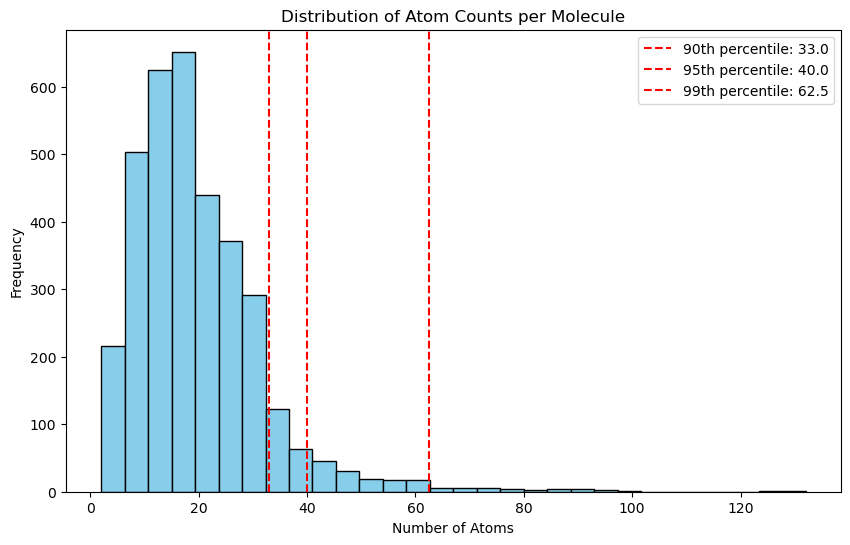

In [113]:
plot_atoms_distribution_from_list(list(combined_df['node_dim']))

In [114]:
combined_df = combined_df[combined_df['node_dim'] <= 63]
combined_df = combined_df[~((combined_df['tox'] == 1) &(combined_df['bio'] == 1))]

In [160]:
combined_df

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
2325,7777.0,C4H10O2S2,NCGC00255960-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8.0
2326,7823.0,C17H11BrClFN2O4,NCGC00254383-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26.0
2327,7826.0,C7H7Br,NCGC00257572-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8.0
2328,7786.0,C7H16BrN,NCGC00260253-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9.0
2329,7818.0,C2HBrCl2O2,NCGC00258477-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
...,...,...,...,...,...,...,...,...
5560,NaN,C10H14O6,NaN,NaN,252.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",16.0
5561,NaN,C3H7Cl,NaN,NaN,604.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",4.0
5562,NaN,C9H13NO8,NaN,NaN,2760.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",18.0
5563,NaN,C25H40N2O9,NaN,NaN,2767.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",36.0


In [115]:
tox_df.iloc[0].data_object

Data(x=[24, 10], edge_index=[2, 23], edge_attr=[23, 4], atom_data=[24, 35])

In [116]:
combined_df.iloc[0].data_object

Data(x=[8, 10], edge_index=[2, 7], edge_attr=[7, 4], atom_data=[8, 35])

In [117]:
combined_df

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
2325,7777.0,C4H10O2S2,NCGC00255960-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8.0
2326,7823.0,C17H11BrClFN2O4,NCGC00254383-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26.0
2327,7826.0,C7H7Br,NCGC00257572-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8.0
2328,7786.0,C7H16BrN,NCGC00260253-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9.0
2329,7818.0,C2HBrCl2O2,NCGC00258477-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
...,...,...,...,...,...,...,...,...
5560,NaN,C10H14O6,NaN,NaN,252.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",16.0
5561,NaN,C3H7Cl,NaN,NaN,604.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",4.0
5562,NaN,C9H13NO8,NaN,NaN,2760.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",18.0
5563,NaN,C25H40N2O9,NaN,NaN,2767.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",36.0


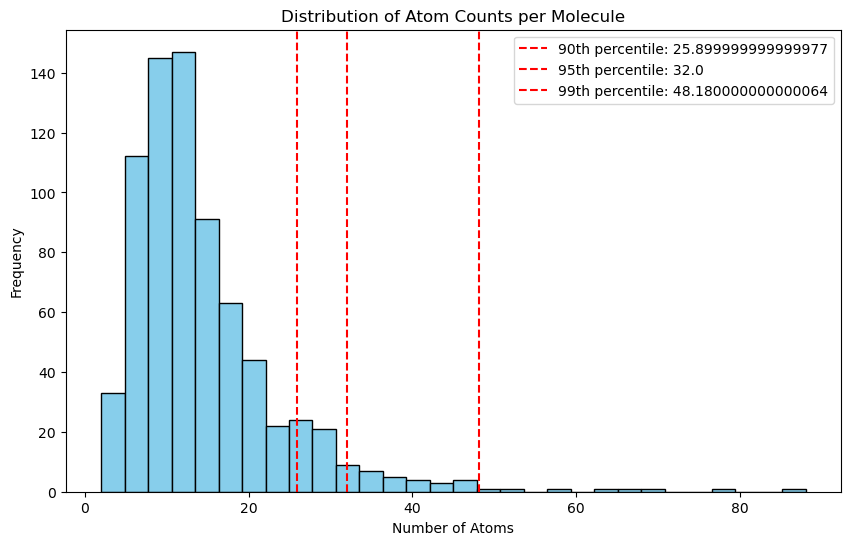

In [137]:
plot_atoms_distribution_from_list(list(bio_df[bio_df['bio'] == 1]['node_dim']))

In [125]:
NODE_MAX = 63

In [135]:
combined_df[combined_df['node_dim'] <= 15]

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
2325,7777.0,C4H10O2S2,NCGC00255960-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8.0
2327,7826.0,C7H7Br,NCGC00257572-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8.0
2328,7786.0,C7H16BrN,NCGC00260253-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9.0
2329,7818.0,C2HBrCl2O2,NCGC00258477-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
2330,7821.0,C4H6Br2,NCGC00260276-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",6.0
...,...,...,...,...,...,...,...,...
5556,NaN,C7H13ClO2,NaN,NaN,590.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",10.0
5557,NaN,C4H8OS2,NaN,NaN,624.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
5558,NaN,C8H19PS2,NaN,NaN,601.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",11.0
5559,NaN,C6H6N2O2S,NaN,NaN,2782.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",11.0


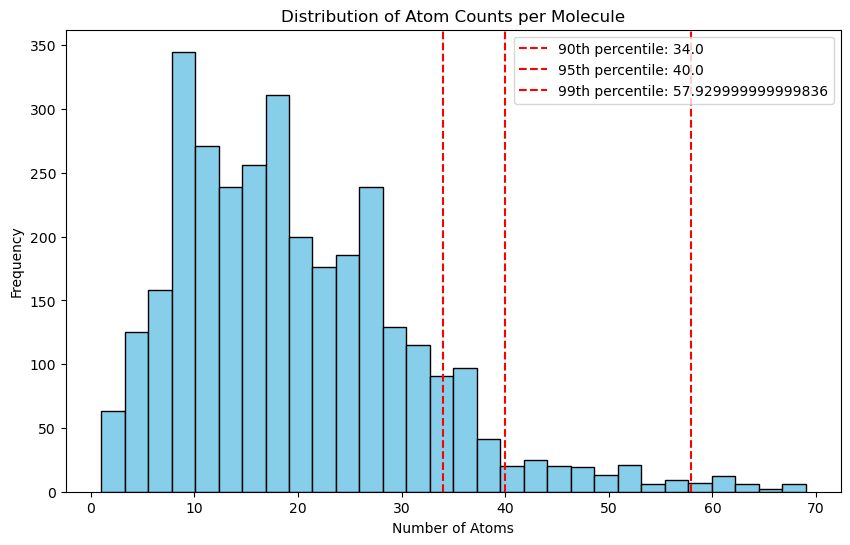

In [145]:
l = []
for d in combined_df.data_object:
    count = d.edge_index.shape[1]
    l.append(int(count))
plot_atoms_distribution_from_list(l)

In [126]:
combined_df_reduced = combined_df[combined_df['node_dim'] <= NODE_MAX]

In [127]:
combined_df_reduced

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
2325,7777.0,C4H10O2S2,NCGC00255960-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8.0
2326,7823.0,C17H11BrClFN2O4,NCGC00254383-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26.0
2327,7826.0,C7H7Br,NCGC00257572-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8.0
2328,7786.0,C7H16BrN,NCGC00260253-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9.0
2329,7818.0,C2HBrCl2O2,NCGC00258477-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
...,...,...,...,...,...,...,...,...
5559,NaN,C6H6N2O2S,NaN,NaN,2782.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",11.0
5560,NaN,C10H14O6,NaN,NaN,252.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",16.0
5561,NaN,C3H7Cl,NaN,NaN,604.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",4.0
5562,NaN,C9H13NO8,NaN,NaN,2760.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",18.0


In [131]:
# bond_tensors = []
# dist_tensors = []
# atomic_number_tensors = []
# for o in list(combined_df['data_object']):
#     b, d, a = convert_to_tensors(o)
#     bond_tensors.append(b)
#     dist_tensors.append(d)
#     atomic_number_tensors.append(a)
# bond_tensors = torch.stack(bond_tensors)
# distance_tensors = torch.stack(dist_tensors)
# atomic_number_tensors = torch.stack(atomic_number_tensors)
bond_tensors = []
# dist_tensors = []
atomic_number_tensors = []
for d in combined_df_reduced['data_object'].tolist():
    # b, d, a = convert_to_tensors(o,10,63)
    b,a = convert_to_tensors(d, 10, NODE_MAX, 4)
    bond_tensors.append(b)
    # dist_tensors.append(d)
    atomic_number_tensors.append(a)
bond_tensors = torch.stack(bond_tensors)
# distance_tensors = torch.stack(dist_tensors)
atomic_number_tensors = torch.stack(atomic_number_tensors)

In [132]:
torch.save(bond_tensors, f'bond_tensors_wgan_{NODE_MAX}.pt')
# torch.save(distance_tensors, 'distance_tensors.pt')
torch.save(atomic_number_tensors, f'atomic_number_tensors_wgan_{NODE_MAX}.pt')

In [133]:
atomic_number_tensors.shape

torch.Size([2925, 33, 11])

In [49]:
combined_df

,index_x,formula,name,tox,index_y,bio,data_object,node_dim
2325,7777.0,C4H10O2S2,NCGC00255960-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 1., 0., ...",8.0
2326,7823.0,C17H11BrClFN2O4,NCGC00254383-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",26.0
2327,7826.0,C7H7Br,NCGC00257572-01,0.0,NaN,NaN,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...",8.0
2328,7786.0,C7H16BrN,NCGC00260253-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",9.0
2329,7818.0,C2HBrCl2O2,NCGC00258477-01,0.0,NaN,NaN,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",7.0
...,...,...,...,...,...,...,...,...
5560,NaN,C10H14O6,NaN,NaN,252.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",16.0
5561,NaN,C3H7Cl,NaN,NaN,604.0,1.0,"[(x, [tensor([1., 0., 0., 0., 0., 0., 0., 0., ...",4.0
5562,NaN,C9H13NO8,NaN,NaN,2760.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",18.0
5563,NaN,C25H40N2O9,NaN,NaN,2767.0,1.0,"[(x, [tensor([0., 0., 1., 0., 0., 0., 0., 0., ...",36.0
